In [4]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import copy
import timm

In [5]:
print(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

cuda


In [6]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 3
EPOCHS = 5
PATIENCE = 3
LEARNING_RATE = 1e-4

In [21]:
train_path = r'C:\Users\Admin\Desktop\Video Classification\dataset\train'
val_path = r'C:\Users\Admin\Desktop\Video Classification\dataset\val'
class_names = ['general', 'obscene', 'violent']

In [8]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [9]:
# Datasets
train_dataset = ImageFolder(train_path, transform=transform)
val_dataset = ImageFolder(val_path, transform=transform)

# Loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)

In [10]:
criterion = nn.CrossEntropyLoss()
def make_model(model_name):
    model = timm.create_model(model_name, pretrained=True)

    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # Replace classification head
    model.head = nn.Linear(model.head.in_features, NUM_CLASSES)
    
    # Train only the new head
    for param in model.head.parameters():
        param.requires_grad = True

    model = model.to(device)
    # Loss and optimizer
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    return model, optimizer

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    import matplotlib.pyplot as plt

    epochs_range = range(1, len(train_losses) + 1)

    # Loss plot
    plt.figure()
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Accuracy plot
    plt.figure()
    plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()


In [13]:
def train_model(model_name, checkpoint_path):
    model, optimizer = make_model(model_name)
    best_acc = 0.0
    patience_counter = 0

    # Tracking metrics
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        running_val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_acc = correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Train Acc = {train_acc*100:.2f}%, "
              f"Val Loss = {avg_val_loss:.4f}, Val Acc = {val_acc*100:.2f}%")

        # Early stopping
        if val_acc > best_acc:
            best_acc = val_acc
            best_model = copy.deepcopy(model.state_dict())
            patience_counter = 0
            torch.save(best_model, checkpoint_path)
            print("New best model saved")
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print("Early stopping triggered")
                break

    # Plotting after training
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

    return model  # optionally return metrics too if needed


vit_tiny_patch16_224 → 86.98% accuracy  
deit_small_patch16_224 → 93.29% accuracy

Epoch 1/5: 100%|██████████| 365/365 [00:39<00:00,  9.28it/s]


Epoch 1: Train Loss = 1.1040, Train Acc = 57.81%, Val Loss = 0.6690, Val Acc = 72.24%
New best model saved


Epoch 2/5: 100%|██████████| 365/365 [00:37<00:00,  9.69it/s]


Epoch 2: Train Loss = 0.5067, Train Acc = 79.54%, Val Loss = 0.4559, Val Acc = 81.48%
New best model saved


Epoch 3/5: 100%|██████████| 365/365 [00:43<00:00,  8.46it/s]


Epoch 3: Train Loss = 0.3793, Train Acc = 84.99%, Val Loss = 0.3764, Val Acc = 85.04%
New best model saved


Epoch 4/5: 100%|██████████| 365/365 [00:46<00:00,  7.92it/s]


Epoch 4: Train Loss = 0.3214, Train Acc = 87.42%, Val Loss = 0.3339, Val Acc = 86.80%
New best model saved


Epoch 5/5: 100%|██████████| 365/365 [00:41<00:00,  8.82it/s]


Epoch 5: Train Loss = 0.2867, Train Acc = 88.72%, Val Loss = 0.3086, Val Acc = 87.20%
New best model saved


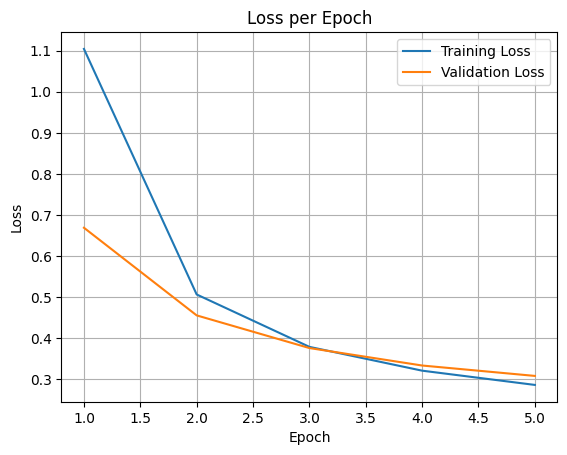

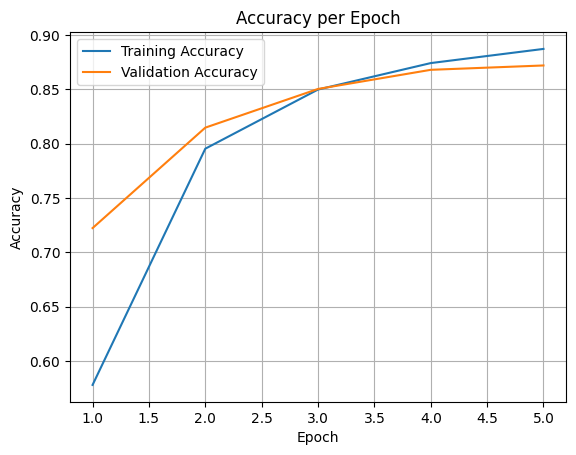

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)


In [14]:
train_model('vit_tiny_patch16_224', 'best_vit_tiny.pt')

Epoch 1/5: 100%|██████████| 365/365 [01:09<00:00,  5.24it/s]


Epoch 1: Train Loss = 0.7802, Train Acc = 64.20%, Val Loss = 0.4422, Val Acc = 85.24%
New best model saved


Epoch 2/5: 100%|██████████| 365/365 [01:10<00:00,  5.17it/s]


Epoch 2: Train Loss = 0.3348, Train Acc = 90.42%, Val Loss = 0.2926, Val Acc = 91.08%
New best model saved


Epoch 3/5: 100%|██████████| 365/365 [01:10<00:00,  5.15it/s]


Epoch 3: Train Loss = 0.2423, Train Acc = 92.82%, Val Loss = 0.2394, Val Acc = 92.28%
New best model saved


Epoch 4/5: 100%|██████████| 365/365 [01:11<00:00,  5.10it/s]


Epoch 4: Train Loss = 0.2019, Train Acc = 93.79%, Val Loss = 0.2110, Val Acc = 92.68%
New best model saved


Epoch 5/5: 100%|██████████| 365/365 [01:12<00:00,  5.07it/s]


Epoch 5: Train Loss = 0.1785, Train Acc = 94.39%, Val Loss = 0.1932, Val Acc = 93.12%
New best model saved


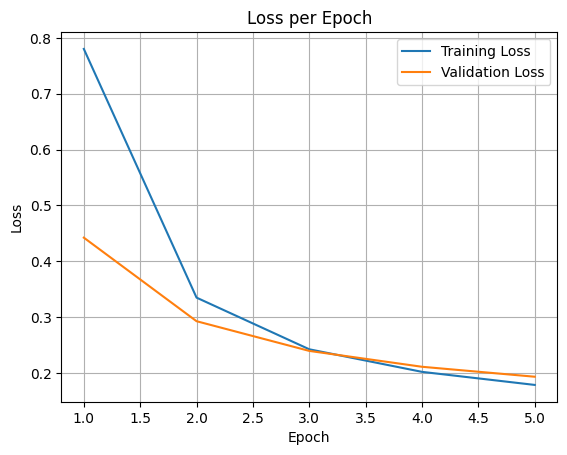

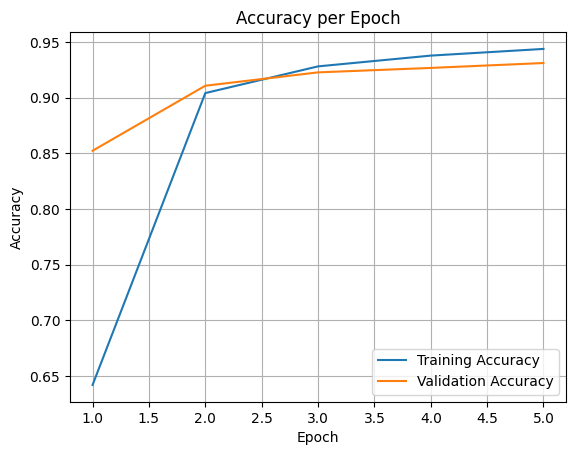

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False

In [15]:
train_model('deit_small_patch16_224', 'best_deit_small.pt')

In [16]:
test_path = r'C:\Users\Admin\Desktop\Video Classification\dataset\test'
# Test dataset and loader
test_dataset = ImageFolder(test_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)


In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def test_model(model_name, checkpoint_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss()

    # Load model
    model = timm.create_model(model_name, pretrained=False, num_classes=NUM_CLASSES)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []
    total_loss = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    avg_loss = total_loss / len(test_loader)
    correct = sum([p == t for p, t in zip(all_preds, all_labels)])
    accuracy = correct / len(all_preds)

    print(f"\nTest Accuracy: {accuracy * 100:.2f}%")
    print(f"Test Loss: {avg_loss:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names if class_names else range(NUM_CLASSES),
                yticklabels=class_names if class_names else range(NUM_CLASSES))
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names if class_names else None))

C:\Users\Admin\AppData\Local\Temp\ipykernel_21468\971644891.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_locati


Test Accuracy: 87.30%
Test Loss: 0.3059


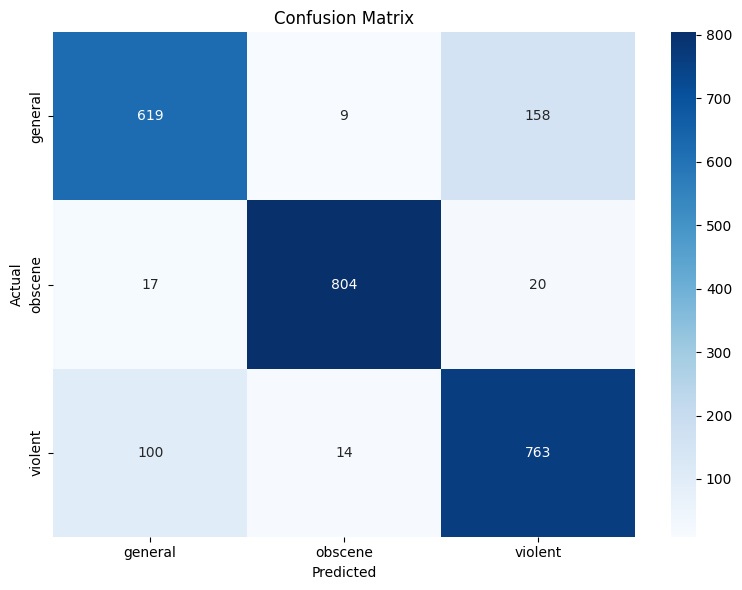


Classification Report:
              precision    recall  f1-score   support

     general       0.84      0.79      0.81       786
     obscene       0.97      0.96      0.96       841
     violent       0.81      0.87      0.84       877

    accuracy                           0.87      2504
   macro avg       0.87      0.87      0.87      2504
weighted avg       0.87      0.87      0.87      2504



C:\Users\Admin\AppData\Local\Temp\ipykernel_21468\971644891.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_locati


Test Accuracy: 93.29%
Test Loss: 0.1921


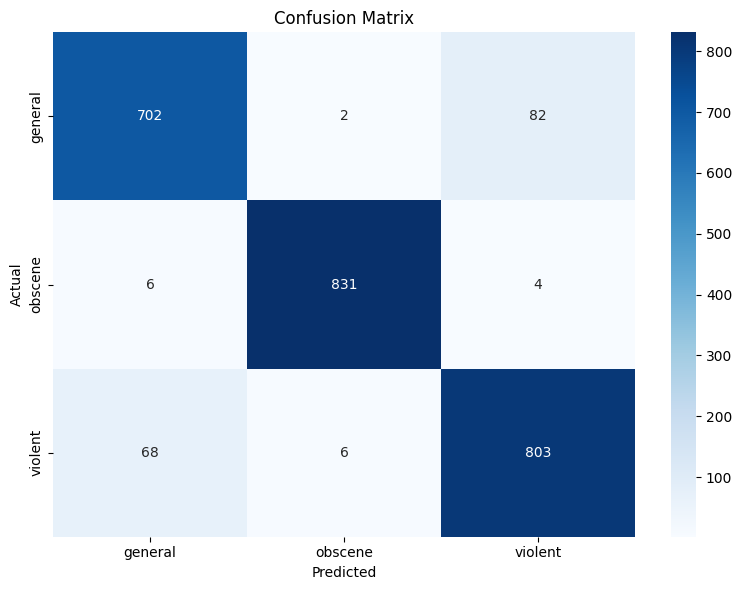


Classification Report:
              precision    recall  f1-score   support

     general       0.90      0.89      0.90       786
     obscene       0.99      0.99      0.99       841
     violent       0.90      0.92      0.91       877

    accuracy                           0.93      2504
   macro avg       0.93      0.93      0.93      2504
weighted avg       0.93      0.93      0.93      2504



In [31]:
test_model('vit_tiny_patch16_224', 'best_vit_tiny.pt')
test_model('deit_small_patch16_224', 'best_deit_small.pt')